# Scikit-learn

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM

from sklearn.metrics import f1_score, classification_report

import warnings
warnings.filterwarnings('ignore')

import argparse
# import wandb
# from wandb.keras import WandbCallback
# wandb.init(project="DACON_235930", name="Tutorial")

parser = argparse.ArgumentParser(description="Tutorial")
parser.add_argument('--model_name', default='if', type=str) # if, lof, ocsvm, sgdocsvm
parser.add_argument('--seed', default=1011, type=int)
args = parser.parse_args('')

# wandb.config.update(args)

model_name = args.model_name
seed = args.seed

def set_seeds(seed=seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    
set_seeds()

train_df = pd.read_csv('/content/drive/MyDrive/DACON_235930/data/train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/DACON_235930/data/val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DACON_235930/data/test.csv')

train_df.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,3,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
1,4,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
2,6,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960
3,8,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901
4,9,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901


## Preprocessing

In [2]:
val_normal, val_fraud = val_df['Class'].value_counts()
val_contamination = val_fraud / val_normal
print(f'Validation contamination : {val_contamination}')

# wandb.log({'val_contamination': val_contamination})

Validation contamination : 0.0010551491277433877


In [3]:
X_train = train_df.drop(columns=['ID'])
X_val = val_df.drop(columns=['ID', 'Class'])
y_val = val_df['Class']
X_test = test_df.drop(columns=['ID'])

X_train.shape, X_val.shape, y_val.shape, X_test.shape

((113842, 30), (28462, 30), (28462,), (142503, 30))

## EDA

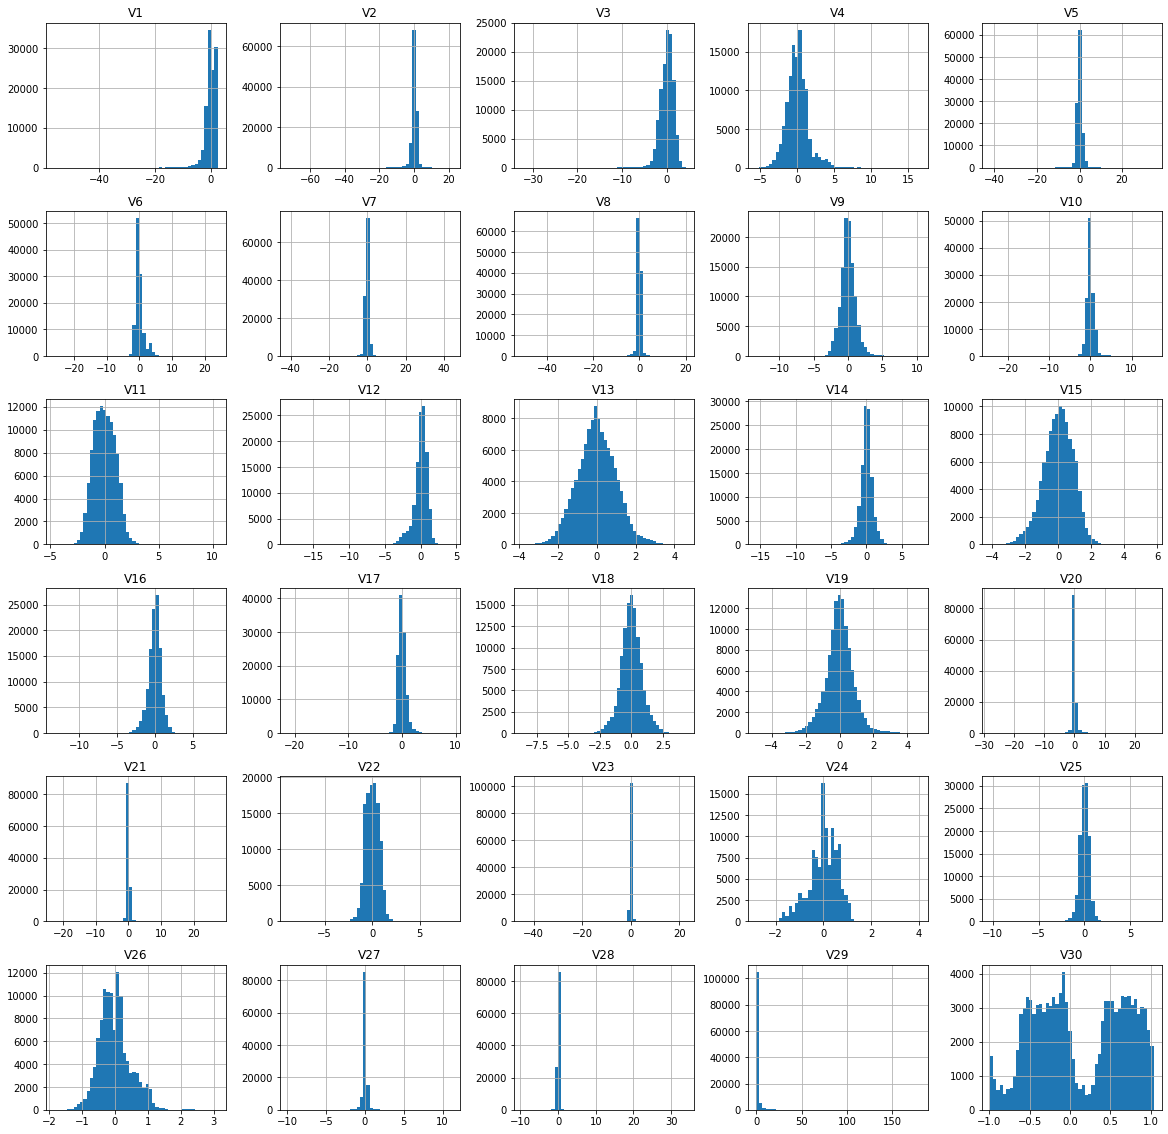

In [4]:
train_df.drop(columns=['ID']).hist(bins=50, figsize=(20,20))
plt.show()

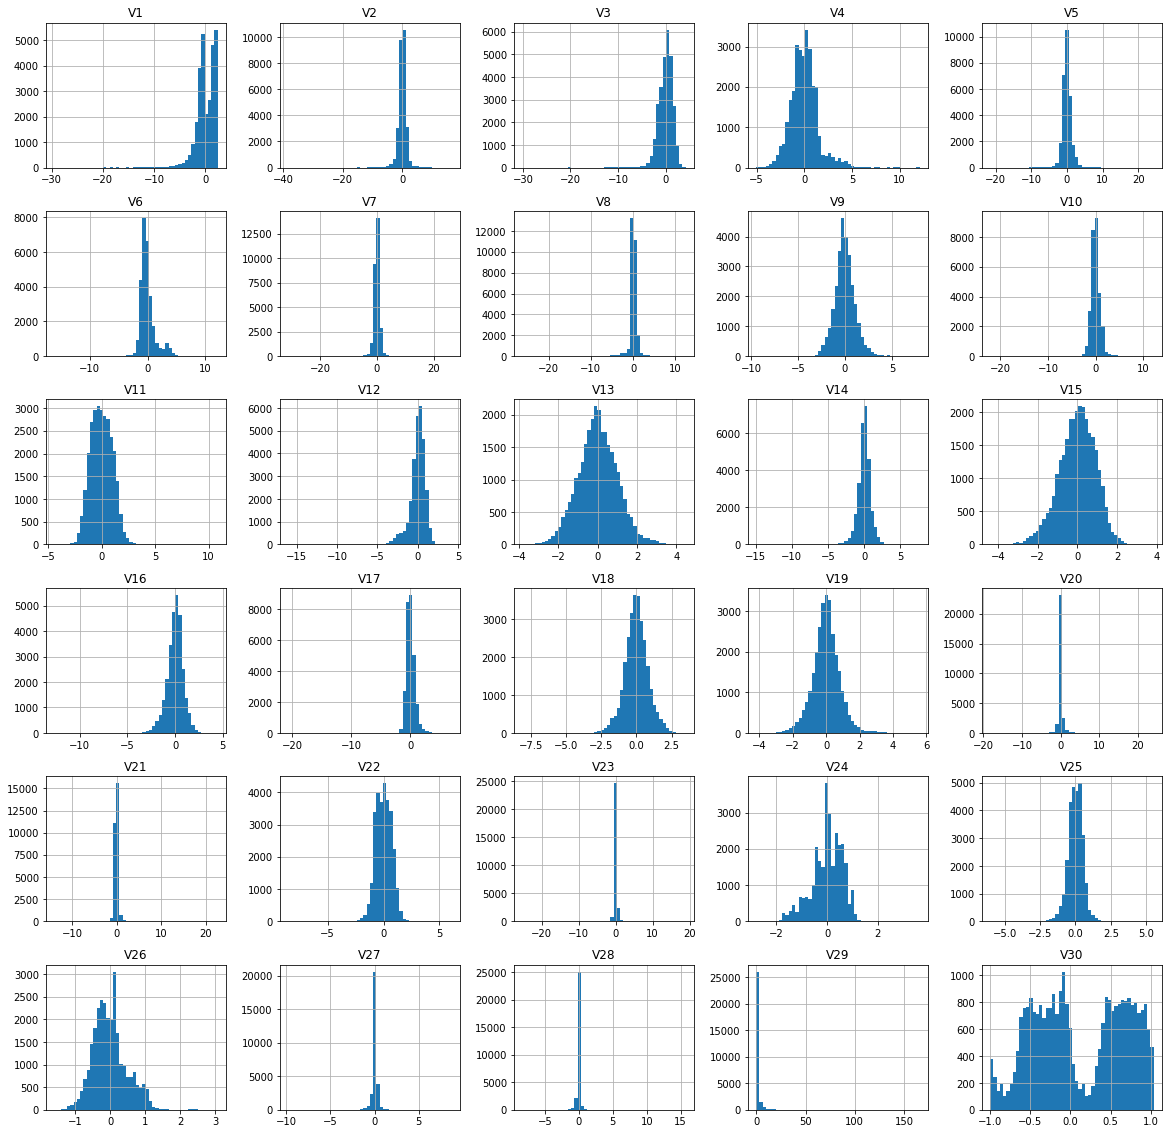

In [5]:
val_df.drop(columns=['ID', 'Class']).hist(bins=50, figsize=(20,20))
plt.show()

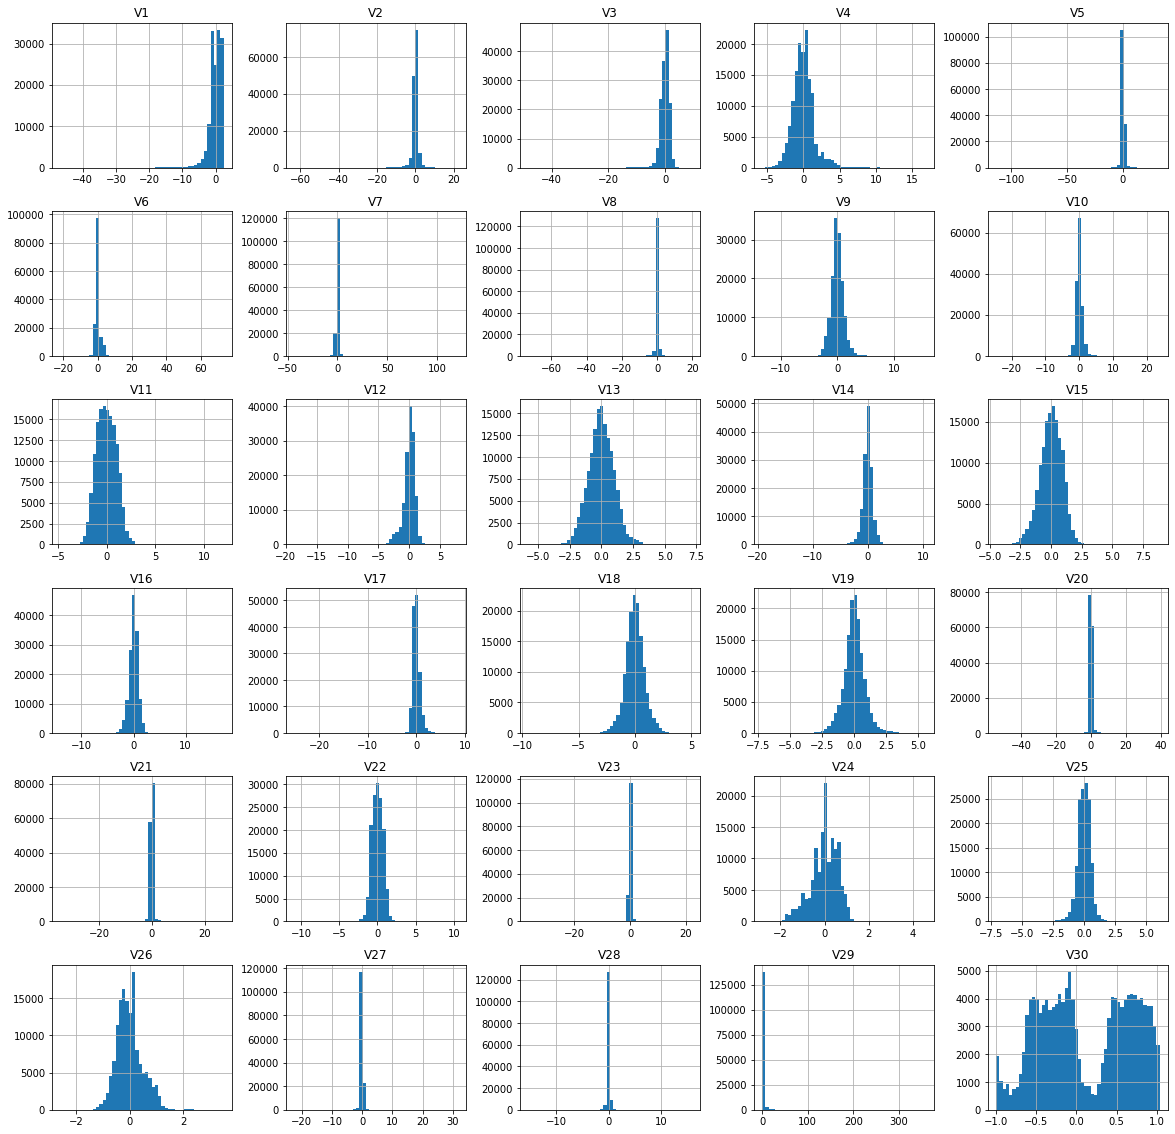

In [6]:
test_df.drop(columns=['ID']).hist(bins=50, figsize=(20,20))
plt.show()

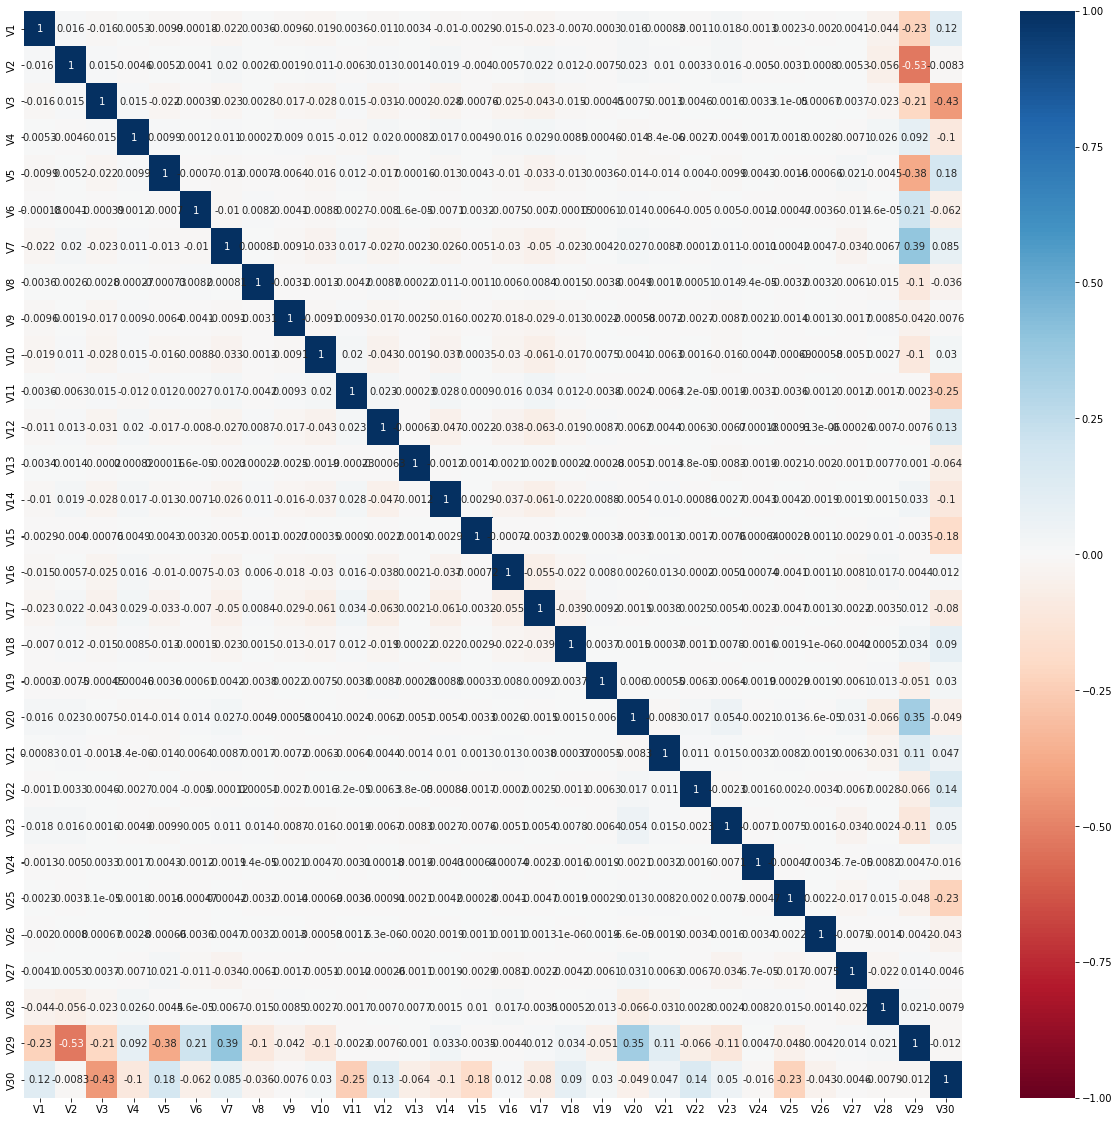

In [7]:
plt.figure(figsize=(21,20))
sns.heatmap(X_train.corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()

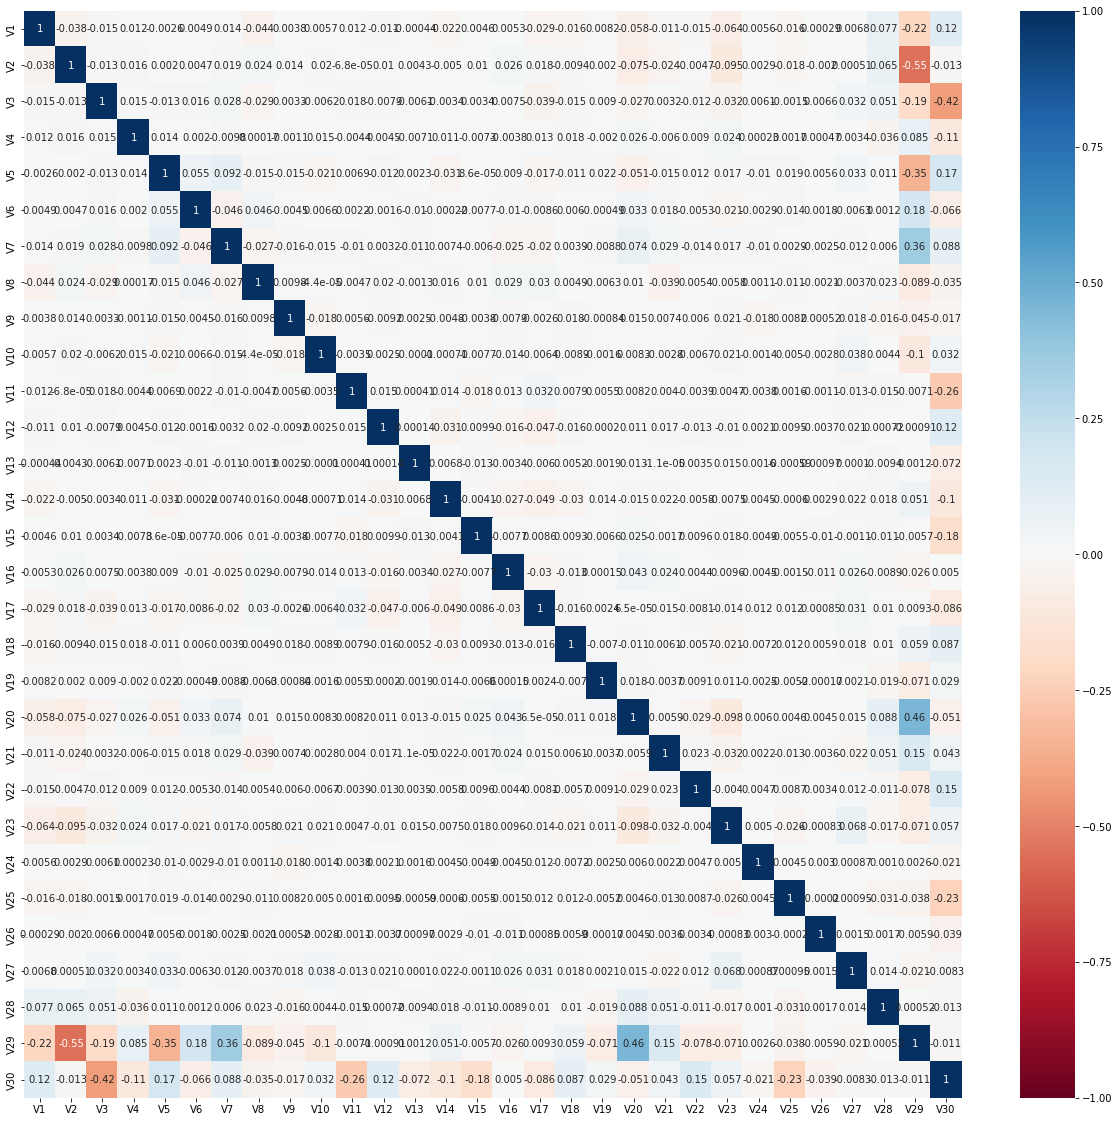

In [8]:
plt.figure(figsize=(21,20))
sns.heatmap(X_val.corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()

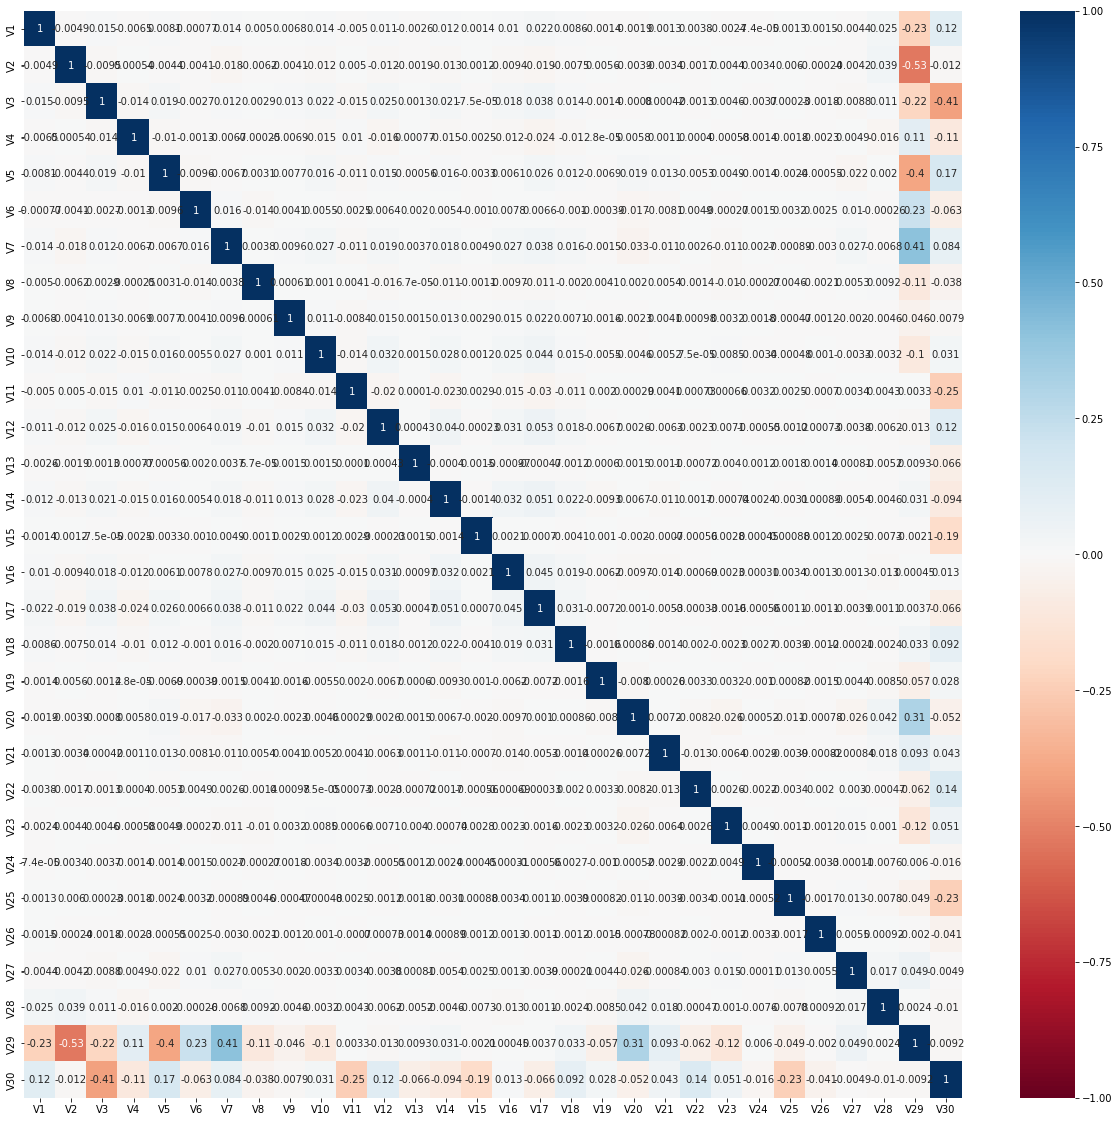

In [9]:
plt.figure(figsize=(21,20))
sns.heatmap(X_test.corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()

## Training

In [10]:
if model_name == "if":
    model = IsolationForest(n_estimators=100,
                            max_samples=len(X_train),
                            contamination=val_contamination,
                            n_jobs=-1,
                            random_state=seed)
elif model_name == "lof":
    model = LocalOutlierFactor(n_neighbors=20,
                               contamination=val_contamination,
                               novelty=True,
                               n_jobs=-1)
elif model_name == "ocsvm":
    model = OneClassSVM()
    
elif model_name == "sgdocsvm":
    model = SGDOneClassSVM(random_state=seed)
    
model.fit(X_train)

IsolationForest(contamination=0.0010551491277433877, max_samples=113842,
                n_jobs=-1, random_state=1011)

In [11]:
def get_pred_label(model_pred):
    model_pred = np.where(model_pred==1, 0, model_pred)
    model_pred = np.where(model_pred==-1, 1, model_pred)
    return model_pred

In [12]:
y_pred = model.predict(X_val)
y_pred = get_pred_label(y_pred)

val_macro_f1 = f1_score(y_val, y_pred, average='macro')
print(f'val_macro_f1 : {val_macro_f1}')

# wandb.log({'val_macro_f1': val_macro_f1})

val_macro_f1 : 0.7065976033191156


## Inference

In [13]:
prediction = model.predict(X_test)
prediction = get_pred_label(prediction)

test_normal, test_fraud = pd.Series(prediction).value_counts()
test_contamination = test_fraud / test_normal
print(f'Test contamination : {test_contamination}')

# wandb.log({'test_contamination': test_contamination})

Test contamination : 0.0013913776747127649


In [14]:
diff_contamination = val_contamination - test_contamination

print(f"diff_contamination : {diff_contamination*100:.4f}")
# wandb.log({'diff_contamination': diff_contamination})

diff_contamination : -0.0336


In [15]:
submission = pd.read_csv('/content/drive/MyDrive/DACON_235930/data/sample_submission.csv')
submission['Class'] = prediction
submission.to_csv('/content/drive/MyDrive/DACON_235930/submission.csv', index=False)